In [4]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
import numpy as np
from tqdm import tqdm_notebook
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 80

device = torch.device('cuda:0')

## Load obj and create Mesh

In [233]:
# Load the target mesh
trg_obj = os.path.join('./1_obj/A00770.obj')
src_obj = os.path.join('./1_obj/A00080.obj')

In [234]:
trg_verts, trg_faces, trg_aux = load_obj(trg_obj)
print(trg_verts.shape)
print(trg_faces.verts_idx.shape)
print(trg_aux)
# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
trg_faces_idx = trg_faces.verts_idx.to(device)
trg_verts = trg_verts.to(device)

torch.Size([1692, 3])
torch.Size([3150, 3])
Properties(normals=None, verts_uvs=None, material_colors=None, texture_images=None)


In [235]:
src_verts, src_faces, src_aux = load_obj(src_obj)
print(src_verts.shape)
print(src_faces.verts_idx.shape)
print(src_aux)
# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
src_faces_idx = src_faces.verts_idx.to(device)
src_verts = src_verts.to(device)

torch.Size([1692, 3])
torch.Size([3150, 3])
Properties(normals=None, verts_uvs=None, material_colors=None, texture_images=None)


#### scale & normalize mesh s.t. fits in a unit sphere

In [236]:
# target mesh
trg_center = trg_verts.mean(0)
trg_verts = trg_verts - trg_center
trg_scale = max(trg_verts.abs().max(0)[0])
trg_verts = trg_verts / trg_scale

# source mesh
src_center = src_verts.mean(0)
src_verts = src_verts - src_center
src_scale = max(src_verts.abs().max(0)[0])
src_verts = src_verts / src_scale

#### construct a Mesh structure for the target mesh

In [237]:
trg_mesh = Meshes(verts=[trg_verts], faces=[trg_faces_idx])
src_mesh = Meshes(verts=[src_verts], faces=[src_faces_idx])

## Visualize meshes

In [238]:
def plot_pointcloud(mesh, meshL=None, meshR=None, title="", save_path=None):
    fig = plt.figure(figsize=(15, 5))
    axs = []

    ax = fig.add_subplot(1, 3, 2, projection='3d')
    axs.append(ax)
    
    num_sample = 5000
    points = sample_points_from_meshes(mesh, num_sample)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1) 
    ax.scatter(x, z, -y, c='k', s=1)
    ax.set_title(title)
    
    if meshL is not None:
        ax = fig.add_subplot(1, 3, 1, projection='3d')
        points = sample_points_from_meshes(meshL, num_sample)
        x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
        ax.scatter(x, z, -y, c='r', s=1)
        ax.set_title('Source\n({:,} points rendered)'.format(num_sample))
        axs.append(ax)
        
    if meshR is not None:
        ax = fig.add_subplot(1, 3, 3, projection='3d')
        points = sample_points_from_meshes(meshR, num_sample)
        x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
        ax.scatter(x, z, -y, c='b', s=1)
        ax.set_title('Target\n({:,} points rendered)'.format(num_sample))
        axs.append(ax)
        
    for a in axs:
        a.set_xlabel('x')
        a.set_ylabel('z')
        a.set_zlabel('y')
        a.view_init(190, 30)
        a.set_xlim([-1, 1])
        a.set_ylim([-1, 1])
        a.set_zlim([-1, 1])
    if save_path is not None:
        plt.savefig(save_path, dpi=80)
        plt.close('all')
    else:
        plt.show()
        plt.close('all')

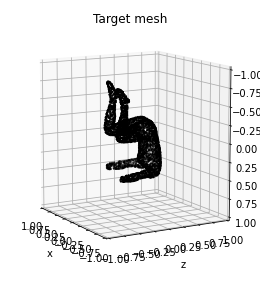

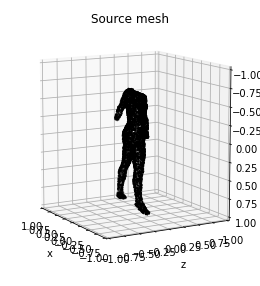

In [239]:
# %matplotlib notebook
plot_pointcloud(trg_mesh, meshL=None, meshR=None, title="Target mesh")
plot_pointcloud(src_mesh, meshL=None, meshR=None, title="Source mesh")

# Optimization loop

In [240]:
# deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

In [241]:
# optimizer
# optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)
optimizer = torch.optim.Adam([deform_verts], lr=0.002)

In [242]:
# number of optimization steps
Niter = 10001

# weight for chamfer loss
w_chamfer = 1.0

# weight for mesh edge loss
w_edge = 1.0

# weight for mesh normal consistency
w_normal = 0.01

# weight for mesh laplacian smoothing
w_laplacian = 0.01

# plot period for losses
plot_period = 250
loop = tqdm_notebook(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # initialize optimizer
    optimizer.zero_grad()
    
    # deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # sample 5k points from the surface for each mesh
    n_samples = 100000
    sample_trg = sample_points_from_meshes(trg_mesh, n_samples)
    sample_src = sample_points_from_meshes(new_src_mesh, n_samples)
    
    # compare the two sets of point clouds using chamfer distance: chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # edge legths of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method='uniform')
    
    # weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # print the losses
    loop.set_description('[{}] Total loss: {:.6f}'.format(i, loss))
    
    # save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)
    
    # plot mesh
    if i % plot_period == 0:
        save_path = './1_output/{}.png'.format(i)
        plot_pointcloud(new_src_mesh, meshL=src_mesh, meshR=trg_mesh, title='Iter: {}\n({:,} control points)'.format(i, n_samples), save_path=save_path)
    
    # optmiziation step
    loss.backward()
    optimizer.step()

<ipython-input-242-d081f6f7aa09>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(Niter))
